# Generation of Bottom-Trapped Internal Tides
Conversion from barotropic to baroclinic tide, linear calculation following [Falahat & Nycander, 2015] (hereafter FN15)

* assume cartesian grid with constant spacing dx, dy (fftconvolve)
* spectral discretization: compute the solutions for different values of $\kappa_n$, then uses linear interpolation
* different data sources: 1 for topo (and reference grid), 1 for tidal components, 1 for mode number (map)


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.basemap import Basemap
import scipy.interpolate as itp
import scipy.signal as sig
import scipy.special as sp    # special functions (bessel)
from netCDF4 import Dataset
import time, os

from convert_TPXO_to_ellipses import get_tpxo8_on_grid
#from PyFVCOM import tidal_ellipse as ellipse


In [3]:
### Parameters 

doverb = True
dosavefig = True

hmical = 200             # min depth to compute solution
hmicon = hmical / 2.     # take contribution from these depths
K1 = 2*np.pi/23.93     # K1 tide frequency [rad/hour] 
g = 9.81               # gravity [m s-2]
Erad = 6371e3          # Earth radius [m]
rho0 = 1025.

Nmodes = 1      # max mode number (starting from mode 1)
Nkas = 10       # number of values for discretizing kn
omega = K1      # frequency of the signal to compute (must be <fcor anywhere)
trunc = 4.1     # truncature (kernel for convolution, K0(4.1) = 1/100)

# options for stratif (wavenumber), grid and tides -- see below:
clim = "FromFile"   # for stratification
topo = "lucky"      # grid and bathymetry
tide = 'tpxo8'      # tide

# plotting
picdir = "pictures"

In [4]:
# --- data location --- define every paths to read data (topo, tides, stratif)
path_data = '/data0/project/vortex/lahaye/'#Tide_Conv/input_data/' #
#path_data = '/net/krypton'+path_data     # if not on LOPS hub
path_alpha = '/net/alpha/exports/sciences/data/REFERENCE_DATA/'

# --- climato ---
if clim == "FromFile":
    cname = path_data+"luckym2_modemap/luckym2_modemap.nc"
else:
    raise ValueError('option for clim not implemented')

# --- topography dataset --- 
if topo == 'lucky':
    file_topo = path_data+"Tide_Conv/input_data/lucky_corgrd.nc"
    varx, vary = 'lon_rho', 'lat_rho'
    varh = 'h'
else:
    raise ValueError('option for topo not implemented')

# --- tide dataset --- 
if tide == 'tpxo8':
    uname = path_alpha+"TIDES/TPXO8/uv.k1_tpxo8_atlas_30c_v1.nc"
    gname = uname.replace("uv.k1","grid")
else:
    raise ValueError('option for tide not implemented')
 

In [5]:
# ------ get topo on the grid, and grid --------
# load the entire grid (regional modelling purpose)
# output: grid (dx, dy), topo, dhdx, dhdy, fcor

nc   = Dataset(file_topo,'r') # etopo2 and srtm30 files have the same structure

if topo == 'lucky':
    lon_h = nc.variables[varx][:].T
    lat_h = nc.variables[vary][:].T
    nlon_h, nlat_h = lon_h.shape
    h_t = nc.variables[varh][:].T      # absolute depth (positive)
    dx_h = 1/nc.variables['pm'][:].T
    dy_h = 1/nc.variables['pn'][:].T
    gang = nc.variables['angle'][:].T  # grid angle (rad., between xi (origin) and E, pos. cc-wise)
nc.close()

dx, dy = dx_h.mean(),dy_h.mean()
dhdx, dhdy = np.gradient(-h_t,dx,dy)   # gradient from algebraic depth
Nx, Ny = h_t.shape

fcor = 2.*(2*np.pi/24.)*np.sin(np.deg2rad(lat_h)) # coriolis, rad/hour

In [6]:
# ------ extract Tides ------------------------------
# output must be complex x- and y- component of barotropic velocity (computation in cartesian coordinates)

if tide == 'tpxo8':
    ure, uim, vre, vim = get_tpxo8_on_grid([uname,gname], lon_h, lat_h, return_what="comp", grang=gang) 
    ue = ure + 1.j*uim
    ve = vre + 1.j*vim
    del ure, uim, vre, vim
    
elif tide == 'lucky':
    raise ValueError("not implemented")
    nc = Dataset(uname,'r')    # all this is old version
    # angle between major axis and east [rad] (beware sign)
    phi = nc.variables['tide_Cangle'][0,...].T
    # tide phase ()
    pha = nc.variables['tide_Cphase'][0,...].T
    # tidal current amplitude (major, minor axes)
    ue = nc.variables['tide_Cmax'][0,...].T
    ve = nc.variables['tide_Cmin'][0,...].T
    nc.close()
    ubt,uphi,vbt,vphi, _ = ellipse.ep2ap(ue,ve/ue,phi+np.rad2deg(phi),pha)  # INC+grang correct ?
    del phi, ue, ve
    
elif tide == 'tpxo7':
    raise ValueError("not implemented, need to modify get_tpxo7_on_grid before")


/home/lahaye/working_on/Int_Tide_Conv/convert_TPXO_to_ellipses.py:187: RuntimeWarning: invalid value encountered in true_divide
  ure = nc.variables['uRe'][indxu,indyu]*1e-4/hu    # cm²/s to m/s
/home/lahaye/working_on/Int_Tide_Conv/convert_TPXO_to_ellipses.py:188: RuntimeWarning: invalid value encountered in true_divide
  vre = nc.variables['vRe'][indxv,indyv]*1e-4/hv
/home/lahaye/working_on/Int_Tide_Conv/convert_TPXO_to_ellipses.py:189: RuntimeWarning: invalid value encountered in true_divide
  uim = nc.variables['uIm'][indxu,indyu]*1e-4/hu
/home/lahaye/working_on/Int_Tide_Conv/convert_TPXO_to_ellipses.py:190: RuntimeWarning: invalid value encountered in true_divide
  vim = nc.variables['vIm'][indxv,indyv]*1e-4/hv


In [7]:
### Modes: read cn and value of modes at bottom from netCDF file, using interpolation
# interpolation using rectBivariateSpline (regular rectangular mesh
# use values of depth of fluid (rescale the fields before interpolation, reduce errors)

# N.B.: can try to define functions that require indices arrays directly 
#       this would avoid evaluating at nan numbers... 

if clim == "FromFile":
    if os.path.isfile(cname):
        nc = Dataset(cname,'r')
        xi = nc.variables['xi_rho'][:]
        eta = nc.variables['eta_rho'][:]
        print("xi in mode file: size={0}, from {1} to {2}".format(xi.size,xi[0],xi[-1]))
        print("eta in mode file: size={0}, from {1} to {2}".format(eta.size,eta[0],eta[-1]))
        nmodes = nc.variables['mode'].size
        print(nmodes,"modes available")
        nc.close()
    else:
        raise ValueError("file "+cname+" not found")
        
def get_cn(imod):
    # return the phase speed, i.e. the eigenvalue cn: an'' + N^2/cn^2*an = 0 (m^2/s^2)
    nc = Dataset(cname,"r")
    cn = nc.variables['mode_speed'][imod,:,:]
    xi = nc.variables['xi_rho'][:]
    eta = nc.variables['eta_rho'][:]   
    if 'topo' in nc.variables:
        subh = nc.variables['topo'][:]
    else:
        subh = h_t[xi,:][:,eta].T
    nc.close()
    cn = cn*subh
    mincn = np.nanmin(cn)
    cn[np.isnan(cn)] = mincn
    xx, yy = np.meshgrid(np.arange(Nx),np.arange(Ny))
    cn = itp.RectBivariateSpline(eta, xi, cn, kx=1, ky=1).ev(yy ,xx)
    cn[cn<=0] = mincn
    return cn.T/h_t

def get_botamp(imod):
    # return the normalized value of an' at the bottom, such that int(an'^2)=1
    nc = Dataset(cname,"r")
    if 'topo' in nc.variables:
        subh = nc.variables['topo'][:]
    else:
        subh = -h_t[xi,:][:,eta].T 
    if "p_norm" in nc.variables:
        pnorm = nc.variables["p_norm"][imod,:,:]
    else:
        dzw = np.diff(nc.variables['zwb'][:],axis=0)
        pmod = nc.variables["p_modes"][imod,:,:,:]
        pnorm = np.nansum(pmod**2*dzw,axis=0)
        del dzw, pmod    
    pmod = nc.variables["p_modes"][imod,0,:,:]
    xx, yy = np.meshgrid(np.arange(Nx),np.arange(Ny))
    pmod = pmod * subh
    pmod[np.isnan(pmod)] = np.nanmin(pmod)
    hh = h_t
    hh[hh<subh.min()] = subh.min()    # adjust value on landpoints
    pmod = itp.RectBivariateSpline(eta, xi, pmod, kx=1, ky=1).ev(yy, xx).T/hh
    pnorm = pnorm / subh
    pnorm[~np.isfinite(pnorm)] = np.nanmax(pnorm)
    pnorm = itp.RectBivariateSpline(eta, xi, pnorm, kx=1, ky=1).ev(yy, xx).T*hh
    pmod[pmod<0] = 0
    pnorm[pnorm<1] = 1
    return pmod/np.sqrt(pnorm)

def cn2kn(cn, fcor=fcor, omega = K1):
    # N.B.: this is also kn2cn
    return np.sqrt(fcor**2 - omega**2)/3600/cn

xi in mode file: size=500, from 2 to 1998
eta in mode file: size=500, from 2 to 1998
10 modes available


In [8]:
###  --  Compute: loop over modes, and over kn (mapping) within each
# N.B.: this could probably be faster if we compute every modes at the same time using a single 
# but extended range for kn (only an' is mode dependent)

# initialize stuff
imodes = 1 + np.arange(Nmodes)
indox, indoy = np.where(h_t > hmical)   # indices where we do the calculation
dhdx, dhdy = ue*dhdx, ve*dhdy           # replace, memory saving
dhdx[h_t<hmicon] = 0.                   # do not take contribution from very shallow zones
dhdy[h_t<hmicon] = 0. 
pn = np.zeros((Nmodes,Nx,Ny)) + 0.j # initialize arrays
un, vn = pn.copy(), pn.copy()

tmes, tmeb = time.clock(), time.time() # monitoring computational time (proc, wall)
for imod in imodes:
    kn = cn2kn(get_cn(imod))        # first step: gen wavelength, initialize array for
    kmin = np.nanmin(kn[h_t>hmical])  # the discrete values used in the convolution
    kmax = np.nanmax(kn[h_t>hmical])
    kns = np.logspace(np.log10(kmin),np.log10(kmax),Nkas)

    # first value of kns (loop initialization -- need 2 values in memory for linear interp)
    k2 = kmin
    nsx = min(max(1,int(trunc/k2/dx)//2) * 2, Nx//2)    # size of kernel for convolution
    nsy = min(max(1,int(trunc/k2/dy)//2) * 2, Ny//2)
    xp, yp = np.arange(-nsx+0.5,nsx)*dx, np.arange(-nsy+0.5,nsy)*dy
    rad = np.sqrt(xp[:,None]**2 + yp[None,:]**2)
    # p
    kern = sp.kn(0,k2*rad)
    kern[rad*k2 > trunc] = 0
    solb = sig.fftconvolve(dhdx, kern, mode="same") + sig.fftconvolve(dhdy, kern, mode = "same")
    # px
    kern = xp/rad*sp.kn(1,k2*rad)
    kern[rad*k2 > trunc] = 0
    soxb = sig.fftconvolve(dhdx, kern, mode="same") + sig.fftconvolve(dhdy, kern, mode = "same")
    # py
    kern = yp/rad*sp.kn(1,k2*rad)
    kern[rad*k2 > trunc] = 0
    soyb = sig.fftconvolve(dhdx, kern, mode="same") + sig.fftconvolve(dhdy, kern, mode = "same")
    print("mode",imod," -- Lk = {0:.2e}, kernel size ({1},{2})".format(2*np.pi/k2/1e3,nsx,nsy) \
            , "timing:", time.clock()-tmes, time.time()-tmeb)
    tmes, tmeb = time.clock(), time.time()
    pp = np.zeros((Nx,Ny)) + 0.j    # get ready for the loop over kns
    px, py = pp.copy(), pp.copy()
    for ik in range(1,Nkas):
        k1, k2 = kns[ik-1:ik+1]
        sola, soxa, soya = solb.copy(), soxb.copy(), soyb.copy()   # copy previous k sols
        inds = np.where( (kn>=k1) & (kn<k2) ) 
        wt = np.array([k2 - kn[inds], kn[inds] - k1]) / (k2 - k1)   # weights for linear interp.
        nsx = min(max(1,int(trunc/k2/dx)//2) * 2, Nx//2)  # size of kernel
        nsy = min(max(1,int(trunc/k2/dy)//2) * 2, Ny//2)
        xp, yp = np.arange(-nsx+0.5,nsx)*dx, np.arange(-nsy+0.5,nsy)*dy
        rad = np.sqrt(xp[:,None]**2 + yp[None,:]**2)
        # p
        kern = sp.kn(0,k2*rad)
        kern[rad*k2 > trunc] = 0    
        solb = sig.fftconvolve(dhdx, kern, mode="same") + sig.fftconvolve(dhdy, kern, mode = "same")
        pp[inds] = wt[0,:]*sola[inds] + wt[1,:]*solb[inds]  # interp values on points concerned
        # px
        kern = xp/rad*sp.kn(1,k2*rad)
        kern[rad*k2 > trunc] = 0
        soxb = sig.fftconvolve(dhdx, kern, mode="same") + sig.fftconvolve(dhdy, kern, mode = "same")
        px[inds] = wt[0,:]*soxa[inds] + wt[1,:]*soxb[inds]  # interp values on points concerned
        # py
        kern = yp/rad*sp.kn(1,k2*rad)
        kern[rad*k2 > trunc] = 0
        soyb = sig.fftconvolve(dhdx, kern, mode="same") + sig.fftconvolve(dhdy, kern, mode = "same")
        py[inds] = wt[0,:]*soya[inds] + wt[1,:]*soyb[inds]  # interp values on points concerned
        
        print("mode",imod," -- Lk = {0:.2e}, kernel size ({1},{2})".format(2*np.pi/k2/1e3,nsx,nsy) \
            , "timing:", time.clock()-tmes, time.time()-tmeb)
        tmes, tmeb = time.clock(), time.time()
    pp[kn>=k2], px[kn>=k2], py[kn>=k2] = solb[kn>=k2], soxb [kn>=k2], soyb[kn>=k2] # almost empty
    del sola, solb, soxa, soxb, soya, soyb
          
    amp = get_botamp(imod)*np.sqrt(cn2kn(kn)/fcor) # normalization according to FN15
    pn[imod-1,:,:] = -1.j*(fcor**2 - omega**2) * amp / (2*np.pi*omega) * pp   # fill the matrix
    un[imod-1,:,:] = -kn * amp / (2*np.pi) * (px + 1.j*fcor/omega * py)
    vn[imod-1,:,:] = -kn * amp / (2*np.pi) * (py - 1.j*fcor/omega * px)
    del amp 
del pp, px, py, kn

# compute modal energy surface density
imod = 1
cn = get_cn(imod)
ekn = rho0/4/abs(fcor/3600.)*( cn*(abs(un[imod-1,:,:])**2 + abs(vn[imod-1,:,:])**2) \
                + abs(pn[imod-1,:,:])**2/cn )

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


mode 1  -- Lk = 1.50e+03, kernel size (1001,1001) timing: 33.431554000000006 33.433454751968384
mode 1  -- Lk = 9.11e+02, kernel size (794,794) timing: 21.770835999999996 21.77962017059326
mode 1  -- Lk = 5.53e+02, kernel size (482,482) timing: 13.779190999999997 13.789304494857788
mode 1  -- Lk = 3.35e+02, kernel size (292,292) timing: 9.506278999999992 9.505236387252808
mode 1  -- Lk = 2.04e+02, kernel size (176,176) timing: 7.867592999999999 7.873651504516602
mode 1  -- Lk = 1.23e+02, kernel size (106,106) timing: 6.3975460000000055 6.404639959335327
mode 1  -- Lk = 7.49e+01, kernel size (64,64) timing: 5.311589999999995 5.311871528625488
mode 1  -- Lk = 4.54e+01, kernel size (38,38) timing: 5.725591999999992 5.7335731983184814
mode 1  -- Lk = 2.76e+01, kernel size (24,24) timing: 5.501809999999992 5.507920503616333
mode 1  -- Lk = 1.67e+01, kernel size (14,14) timing: 6.474760000000003 6.480714321136475


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater


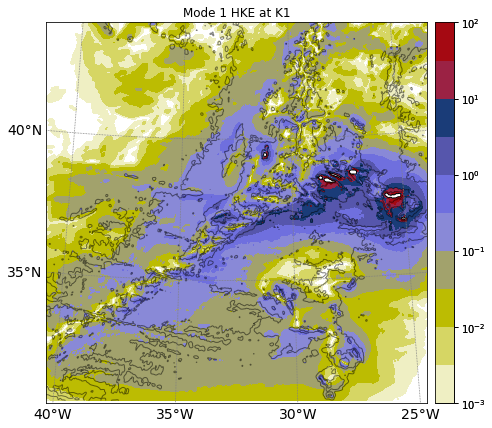

In [9]:
### plotting -- log scale
toplot = ekn.T

valmin = 1e-3
valmax = 1e2
levels = np.logspace(np.log10(valmin),np.log10(valmax),11)
Lx, Ly = Nx*dx, Ny*dy
zlevs = [1000,2000,3500]
fs       = 14
proj     = 'lcc'
res      = 'i'
stride   = 5
topocol='k'     # isobath. contour color
grdcol='gray'   # grid color
cmap = "gist_stern_r"
    
### do the plot
fig = plt.figure(figsize=(8,7))
ax = plt.subplot(111)
bm = Basemap(projection=proj,resolution=res,lon_0=lon_h.mean(),
        lat_0=lat_h.mean(),width=Lx,height=Ly)
xx, yy = bm(lon_h.T, lat_h.T)
bm.drawcoastlines(color='black')
bm.fillcontinents(color='white')
bm.drawparallels(np.arange(-60,70,stride),labels=[1,0,0,0],linewidth=0.8,\
                fontsize=fs,color=grdcol)
bm.drawmeridians(np.arange(-100,100,stride),labels=[0,0,0,1],linewidth=0.8,\
                fontsize=fs,color=grdcol)

bm.contour(xx, yy, h_t.T, zlevs, colors=topocol, linewidths=1, alpha=0.5)

hpc = bm.contourf(xx, yy, toplot, levels, cmap=cmap, norm=colors.LogNorm(), linestyles=None)
hcb = bm.colorbar(hpc)

for item in hpc.collections:
    item.set_rasterized('True')
hcb = bm.colorbar(hpc,extend="both")
#hcb.set_ticks(np.r_[0,hcb.get_ticks()])
#hcb.formatter.set_powerlimits((-1, 1))
#hcb.formatter.set_useMathText(True)
plt.title('Mode {} HKE at K1'.format(imod))

for item in hpc.collections:
    item.set_rasterized('True')
hcb.update_ticks()

if dosavefig:
    plt.savefig(picdir+"trapped_HKE_mode{}.pdf".format(imod), magnification="auto", dpi=200, bbox_inches="tight")